In [1]:
import cv2
import numpy as np

import torch as th
import torch.nn.functional as F

# video rendering deps
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import imageio
from IPython.display import Video

import gym
import gym_minigrid
import hwm.gym_minigrid_2.fourroom_cstm # custom FourRoom envs
from gym_minigrid.wrappers import ReseedWrapper
from hwm.gym_minigrid_2.wrappers import RGBImgFullGridWrapper, ChannelFirstImgWrapper, \
    RGBImgResizeWrapper, ActionMaskingWrapper, FactoredStateRepWrapper, RenderWithoutHighlightWrapper

from stable_baselines3 import PPO
# from stable_baselines3.common.env_util import make_vec_env

import os
from typing import Any, Callable, Dict, Optional, Type, Union
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecEnv

def make_vec_env(
    env_id: Union[str, Type[gym.Env]],
    n_envs: int = 1,
    seed: Optional[int] = None,
    start_index: int = 0,
    monitor_dir: Optional[str] = None,
    wrapper_class: Optional[Callable[[gym.Env], gym.Env]] = None,
    env_kwargs: Optional[Dict[str, Any]] = None,
    vec_env_cls: Optional[Type[Union[DummyVecEnv, SubprocVecEnv]]] = None,
    vec_env_kwargs: Optional[Dict[str, Any]] = None,
    monitor_kwargs: Optional[Dict[str, Any]] = None,
    wrapper_kwargs: Optional[Dict[str, Any]] = None,
    ) -> VecEnv:
    """
    Create a wrapped, monitored ``VecEnv``.
    By default it uses a ``DummyVecEnv`` which is usually faster
    than a ``SubprocVecEnv``.

    :param env_id: the environment ID or the environment class
    :param n_envs: the number of environments you wish to have in parallel
    :param seed: the initial seed for the random number generator
    :param start_index: start rank index
    :param monitor_dir: Path to a folder where the monitor files will be saved.
        If None, no file will be written, however, the env will still be wrapped
        in a Monitor wrapper to provide additional information about training.
    :param wrapper_class: Additional wrapper to use on the environment.
        This can also be a function with single argument that wraps the environment in many things.
    :param env_kwargs: Optional keyword argument to pass to the env constructor
    :param vec_env_cls: A custom ``VecEnv`` class constructor. Default: None.
    :param vec_env_kwargs: Keyword arguments to pass to the ``VecEnv`` class constructor.
    :param monitor_kwargs: Keyword arguments to pass to the ``Monitor`` class constructor.
    :param wrapper_kwargs: Keyword arguments to pass to the ``Wrapper`` class constructor.
    :return: The wrapped environment
    """
    env_kwargs = {} if env_kwargs is None else env_kwargs
    vec_env_kwargs = {} if vec_env_kwargs is None else vec_env_kwargs
    monitor_kwargs = {} if monitor_kwargs is None else monitor_kwargs
    wrapper_kwargs = {} if wrapper_kwargs is None else wrapper_kwargs

    def make_env(rank):
        def _init():
            env = gym.make(env_id, **env_kwargs)
            
            if not wrapper_kwargs["no_reseed"]:
                env = ReseedWrapper(env, seeds=wrapper_kwargs["env_seeds"])
            else:
                env.seed(seed + rank)
                env.action_space.seed(seed + rank)
            
            if len(wrapper_kwargs["env_masked_actions"]):
                env = ActionMaskingWrapper(env, invalid_actions_list=wrapper_kwargs["env_masked_actions"])
            
            env = FactoredStateRepWrapper(env)
            env = RenderWithoutHighlightWrapper(env)

            # Wrap the env in a Monitor wrapper
            # to have additional training information
            monitor_path = os.path.join(monitor_dir, str(rank)) if monitor_dir is not None else None
            # Create the monitor folder if needed
            if monitor_path is not None:
                os.makedirs(monitor_dir, exist_ok=True)
            env = Monitor(env, filename=monitor_path, **monitor_kwargs)
            # Optionally, wrap the environment with the provided wrapper
            if wrapper_class is not None:
                env = wrapper_class(env, **wrapper_kwargs)
            return env

        return _init

    # No custom VecEnv is passed
    if vec_env_cls is None:
        # Default: use a DummyVecEnv
        vec_env_cls = DummyVecEnv

    return vec_env_cls([make_env(i + start_index) for i in range(n_envs)], **vec_env_kwargs)


In [2]:
# Dataset parameterization
# Parallel environments
ENV_NAME = "MiniGrid-FourRooms-Size11-v0"

wrapper_kwargs = {
    "no_reseed": False,
    "env_seeds": [222],
    "env_masked_actions": ["pickup", "drop", "toggle", "done"]
}
env = make_vec_env(ENV_NAME, n_envs=1, wrapper_kwargs=wrapper_kwargs)

# IMPORTANT: Defines the size of the dataset
TRAIN_DATASET_SIZE = int(1e5)

# Set dataset filename
dataset_filename = f"datasets/{ENV_NAME}_SB3_PPOAgent_WithHWMPaddedData_{TRAIN_DATASET_SIZE}"

# Agent SB3 model loading
model = PPO.load("models/PPO_MiniGrid-FourRooms-Size11-v0_Agent")

In [3]:
obs = env.reset()
dones = np.zeros(1)
video_data = [env.render(mode="rgb_array")]
while dones.sum() < 1:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    video_data.append(env.render(mode="rgb_array"))

video_data = np.array(video_data, dtype=np.uint8)
imageio.mimwrite('/tmp/observer_video.mp4', video_data, fps=4)
IPython.display.display(Video("/tmp/observer_video.mp4", html_attributes="controls autoplay loop"))
# video_data.shape

## Generating dataset

In [4]:

# agent_pov_obs_shape = agent_obs_data.shape[1:]
observer_obs_shape = video_data.shape[1:]
agent_pov_obs_shape = (64,64,3) # Note: PPO uses 84x84x3 though
act_shape = env.action_space.n

# NOTE: since we have defined max ep length, we could also do the padding otgether here 
MAX_EP_LENGTH = 20 # Defines the maximum length of an episode that is to be collected.
observer_obs_shape, agent_pov_obs_shape, act_shape

# Padding info
PAD_RIGHT = PAD_LEFT = 1
PADDED_SEQ_LENGTH = PAD_RIGHT + MAX_EP_LENGTH + PAD_LEFT

# Helper for image scaling
def scale_img(a, old_min=0., old_max=255., new_min=-1, new_max=1.):
    assert old_min < old_max, f"Invalid scaling: old_min {old_min} >= old_max: {old_max}"
    assert new_min < new_max, f"Invalid scaling: new_min {new_min} >= new_max: {new_max}"
    return ((a - old_min) * (new_max - new_min)) / (old_max - old_min) + new_min

def generate_dataset(dataset_filename, max_steps, mode="Train"):
    dataset = {
        "observations": [],
        "actions": [], # alreayd one hot
        # "next_observations": np.zeros([DATASET_SIZE, *obs_shape]),
        "rewards": [],
        "terminals": [],
        "rendered_observations": [], # Human observer observations, usually higher dimension
        "factored_states": [],

        # Padded dataset
        "padded_observations": [],
        "padded_actions": [],
        "padded_terminals": [],
        "padded_factored_states": [],
        "depad_masks": [],
        "depad_slices": [],
        "unpadded_ep_lengths": [],

        # Metadata
        "padded_length": PADDED_SEQ_LENGTH,
        "max_length": MAX_EP_LENGTH, # Trajectory length, without the padding
        "act_shape": act_shape,
        "rendered_observation_shape": observer_obs_shape,
    }

    total_steps = 0
    n_eps = 0

    while total_steps < max_steps:
        ep_obs, ep_rendered_obs, ep_actions, \
            ep_rewards, ep_terminals, ep_factored_states = \
            [], [], [], [], [], []
        ep_length = 0

        obs = env.reset()
        dones = np.zeros(1)
        
        while dones.sum() < 1:
            rendered_obs = env.render(mode="rgb_array")

            with th.no_grad():
                action, _states = model.predict(obs)
            # Do one environment step
            next_obs, rewards, dones, info = env.step(action)
            # Save the data of the current time step
            onehot_action = np.eye(act_shape)[action[0]]

            ep_factored_states.append(obs[0])
            ep_actions.append(onehot_action)
            ep_rewards.append(rewards)
            ep_terminals.append(dones)
            # TODO: add permute to C,H,W directy here. Reduce computation during the training.
            ep_obs.append(scale_img(
                cv2.resize(rendered_obs * 1., agent_pov_obs_shape[:2],
                interpolation=cv2.INTER_AREA)))
            ep_rendered_obs.append(rendered_obs)

            obs = next_obs

            ep_length += 1
            # total_steps += 1

        
        # Episode done, append trajectory to the dataset in case it fits the various restrictions
        # otherwise, sack it
        # NOTE: using np.uint8 when possible decreased the required storage space
        # at least in system memory
        # Tranpose the observations from [T,H,W,C] to [T,C,H,W] to match Pytorchs requirement
        # and save computation time during training.
        # The observation is also scaled to the range of -1,1 here to reduce the repetitive
        # computation during training
        if ep_length <= MAX_EP_LENGTH:
            dataset["observations"].append(np.array(ep_obs, dtype=np.float32).transpose(0,3,1,2))
            dataset["actions"].append(np.array(ep_actions, dtype=np.uint8))
            dataset["rewards"].append(np.array(ep_rewards, dtype=np.float32))
            dataset["terminals"].append(np.array(ep_terminals, dtype=np.float32))
            dataset["rendered_observations"].append(np.array(ep_rendered_obs, dtype=np.uint8))
            dataset["factored_states"].append(np.array(ep_factored_states, dtype=np.uint8))

            # adding the padded data
            padded_observations = np.zeros([PADDED_SEQ_LENGTH, *ep_obs[-1].shape[::-1]], dtype=np.float32)
            padded_observations[PAD_RIGHT:PAD_RIGHT+ep_length] = np.array(ep_obs, dtype=np.float32).transpose(0,3,1,2)

            padded_actions = np.zeros([PADDED_SEQ_LENGTH, ep_actions[-1].shape[-1]], dtype=np.uint8)
            padded_actions[PAD_RIGHT:PAD_RIGHT+ep_length] = np.array(ep_actions, dtype=np.uint8)

            padded_terminals = np.zeros([PADDED_SEQ_LENGTH, 1], dtype=np.float32)
            padded_terminals[PAD_RIGHT:PAD_RIGHT+ep_length] = np.array(ep_terminals, dtype=np.float32)

            padded_factored_states = np.zeros([PADDED_SEQ_LENGTH, ep_factored_states[-1].shape[-1]], dtype=np.uint8)
            padded_factored_states[PAD_RIGHT:PAD_RIGHT+ep_length] = np.array(ep_factored_states, dtype=np.uint8)

            depad_mask = np.zeros([MAX_EP_LENGTH, 1], np.float32)
            depad_mask[:ep_length] = 1.

            depad_slice = np.array([PAD_RIGHT, PAD_RIGHT + ep_length], dtype=np.uint8)

            # Checking that the padded data is valid
            assert (padded_observations[depad_slice[0]:depad_slice[1]] == np.array(ep_obs, dtype=np.float32).transpose(0,3,1,2)).all(), \
                "Test on the padded observation data failed"
            assert (padded_actions[depad_slice[0]:depad_slice[1]] == np.array(ep_actions, dtype=np.uint8)).all(), \
                "Test on the padded actions data failed"
            assert (padded_terminals[depad_slice[0]:depad_slice[1]] == np.array(ep_terminals, dtype=np.float32)).all(), \
                "Test on the padded terminals data failed"
            assert (padded_factored_states[depad_slice[0]:depad_slice[1]] == np.array(ep_factored_states, dtype=np.uint8)).all(), \
                "Test on the padded factored states data failed"
            assert (int(np.sum(depad_mask)) == ep_length), "Test on depad_mask failed."

            dataset["padded_observations"].append(padded_observations)
            dataset["padded_actions"].append(padded_actions)
            dataset["padded_terminals"].append(padded_terminals)
            dataset["padded_factored_states"].append(padded_factored_states)
            dataset["depad_masks"].append(depad_mask)
            dataset["depad_slices"].append(depad_slice)
            dataset["unpadded_ep_lengths"].append(ep_length)

            n_eps += 1
            total_steps += ep_length

        if n_eps % 100 == 0 :
            print(f"Sampled {n_eps} eps / Total steps: {total_steps}")
    # TODO: maybe add a metadata field into the dataset to stor ethe min and max lengths of trajectories
    # in the dataset, and so on.

    ep_lengths = [len(ep_terminal_list) for ep_terminal_list in dataset["terminals"]]
    dataset["max_ep_length"] = int(np.max(ep_lengths))
    dataset["min_ep_length"] = int(np.min(ep_lengths))
    dataset["act_shape"] = act_shape
    dataset["factored_state_shape"] = obs.shape[-1]
    dataset["observation_shape"] = ep_obs[-1].shape[::-1] # Breaks if the Height and width are different.
    dataset["rendered_observation_shape"] = ep_rendered_obs[-1].shape
    dataset["n_episodes"] = len(ep_lengths)

    # Save the collected data dict
    np.savez_compressed(f"{dataset_filename}.npz", **dataset)

    return dataset

In [5]:
# Complete dset for HWM
train_dset = generate_dataset(dataset_filename, TRAIN_DATASET_SIZE)

Sampled 100 eps / Total steps: 1167
Sampled 200 eps / Total steps: 2311
Sampled 300 eps / Total steps: 3483
Sampled 400 eps / Total steps: 4668
Sampled 500 eps / Total steps: 5860
Sampled 600 eps / Total steps: 7068
Sampled 700 eps / Total steps: 8204
Sampled 800 eps / Total steps: 9363
Sampled 800 eps / Total steps: 9363
Sampled 900 eps / Total steps: 10455
Sampled 1000 eps / Total steps: 11636
Sampled 1100 eps / Total steps: 12800
Sampled 1200 eps / Total steps: 13933
Sampled 1300 eps / Total steps: 15097
Sampled 1400 eps / Total steps: 16299
Sampled 1500 eps / Total steps: 17483
Sampled 1600 eps / Total steps: 18685
Sampled 1700 eps / Total steps: 19851
Sampled 1800 eps / Total steps: 20971
Sampled 1900 eps / Total steps: 22103
Sampled 2000 eps / Total steps: 23252
Sampled 2100 eps / Total steps: 24394
Sampled 2200 eps / Total steps: 25541
Sampled 2300 eps / Total steps: 26658
Sampled 2400 eps / Total steps: 27800
Sampled 2500 eps / Total steps: 28953
Sampled 2600 eps / Total steps:

/home/d055/anaconda3/envs/hwm/lib/python3.8/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [10]:
# checking the dataset, namely the consistency of the various fields saved
print("obs. shape: ", train_dset["observations"][0].shape)
print("rendered obs. shape: ", train_dset["rendered_observations"][0].shape)
print("actions shape: ", train_dset["actions"][0].shape)
print("rewards shape: ", train_dset["rewards"][0].shape)
print("terminals shape: ", train_dset["terminals"][0].shape)
print("factored_states shape: ", train_dset["factored_states"][0].shape)
print("")

## padded data stats
print("padded obs. shape: ", train_dset["padded_observations"][0].shape)
print("padded actions shape: ", train_dset["padded_actions"][0].shape)
print("padded terminals shape: ", train_dset["padded_terminals"][0].shape)
print("padded factored_states shape: ", train_dset["padded_factored_states"][0].shape)

print("")
# Getting some stats from the dataset
ep_lengths = [len(ep_terminal_list) for ep_terminal_list in train_dset["terminals"]]
print(f"Mean ep. length: {np.mean(ep_lengths)}")
print(f"Median ep. length: {np.median(ep_lengths)}")
print(f"Min. ep. length: {np.min(ep_lengths)}")
print(f"Max. ep. length: {np.max(ep_lengths)}")
print(f"Std. Dev. ep. length: {np.std(ep_lengths)}")

# print(train_dset["metadata"])

obs. shape:  (9, 3, 64, 64)
rendered obs. shape:  (9, 352, 352, 3)
actions shape:  (9, 3)
rewards shape:  (9, 1)
terminals shape:  (9, 1)
factored_states shape:  (9, 36)

padded obs. shape:  (22, 3, 64, 64)
padded actions shape:  (22, 3)
padded terminals shape:  (22, 1)
padded factored_states shape:  (22, 36)

Mean ep. length: 11.537378864790032
Median ep. length: 11.0
Min. ep. length: 3
Max. ep. length: 20
Std. Dev. ep. length: 3.2516881641562296


In [11]:
# Visualizing the depad masks
ep_idx = 1
obs_list = train_dset["observations"][ep_idx]
padded_obs_list = train_dset["padded_observations"][ep_idx]
depad_mask = train_dset["depad_masks"][ep_idx]
ep_real_length = train_dset["unpadded_ep_lengths"][ep_idx]

obs_list[:, :, 0, 0], padded_obs_list[:, :, 0, 0], depad_mask, ep_real_length, len(padded_obs_list)
# depad_mask.reshape(-1,1,1,1).shape
# (padded_obs_list[1:-1] * depad_mask.reshape(-1,1,1,1)).shape

(array([[-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.        ],
        [-0.21568623, -0.21568623, -0.21568623],
        [-0.21568623, -0.21568623, -0.21568623],
   

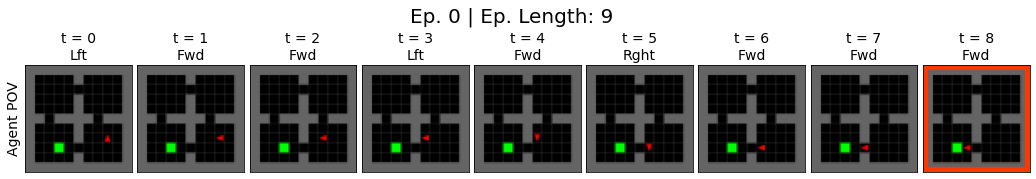

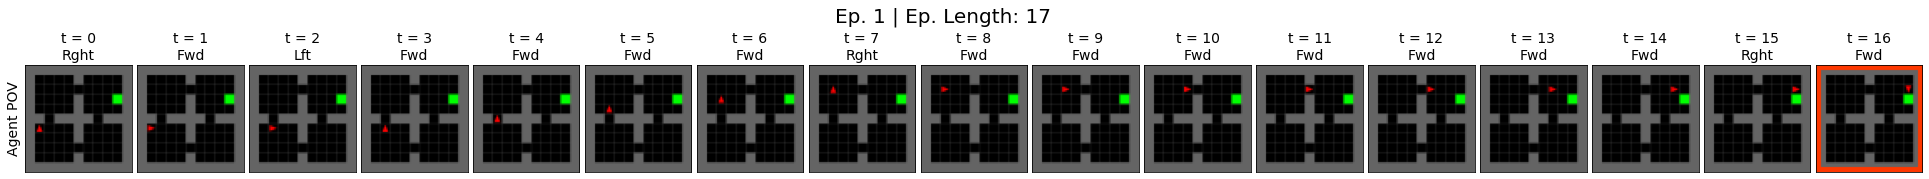

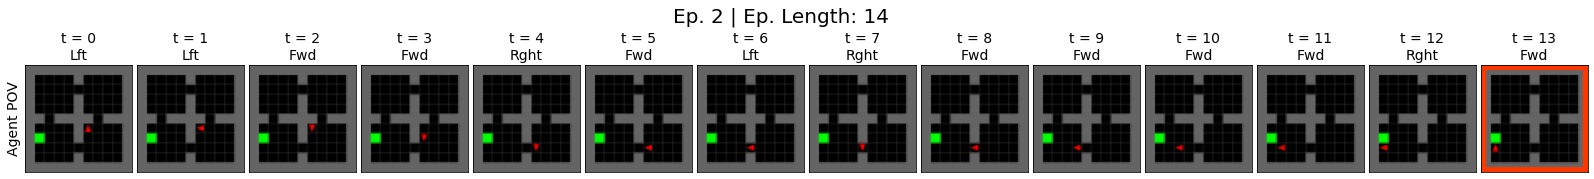

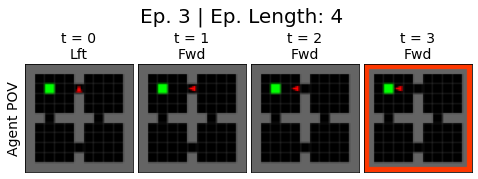

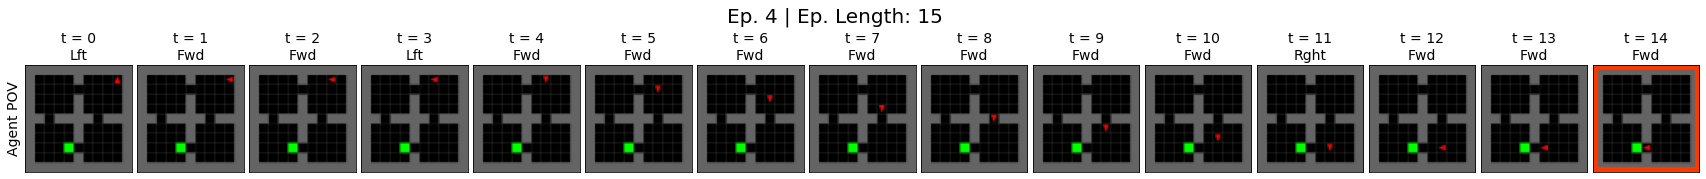

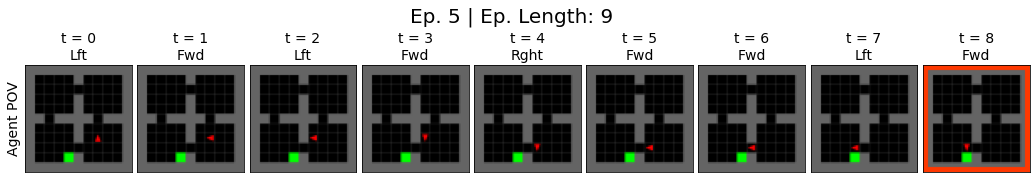

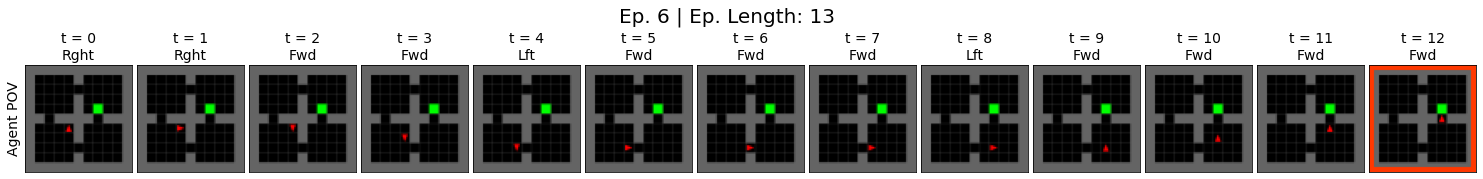

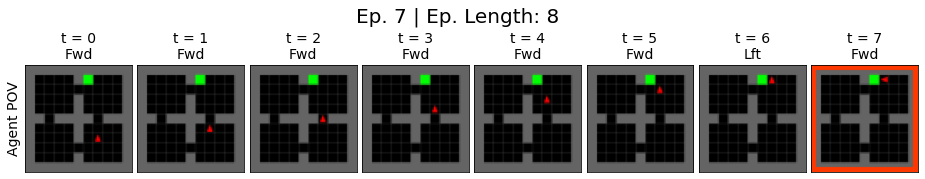

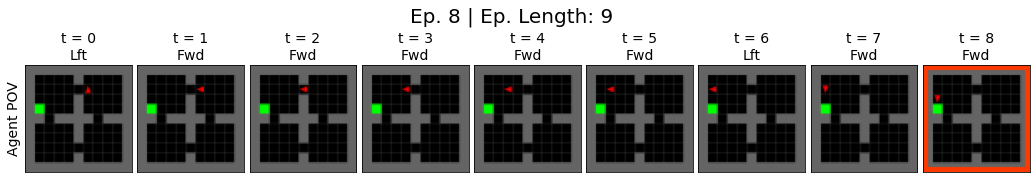

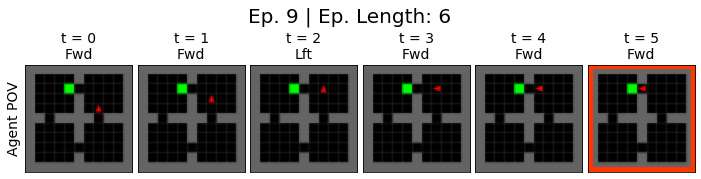

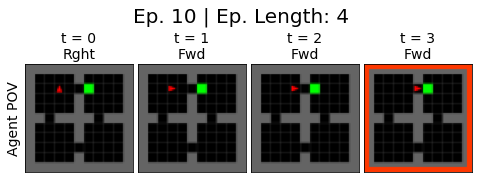

In [12]:
# Qualitative check of the data saved
# Plotting stuff
PLOT_SCALE = 1.
AX_WIDTH, AX_HEIGHT = 2,2
EP_TO_PLOT = len(ep_lengths) # N rows
from hwm.gym_minigrid.metadata import ACTION_META_DICT
from hwm.utils import draw_color_over_frame
COOL_GREY = (0.55,0.57,0.67)
COQUELICOT = (1.0, .22, .0)
# NOTE: if the env masks some actions, need to accout for it later
# HWM Hyper parameters
hwm_init_size = 3

for ep_idx, (ep_agent_obs_list, ep_action_list, ep_terminal_list) in \
    enumerate(zip(train_dset["observations"], train_dset["actions"], train_dset["terminals"])):
    ep_length = len(ep_agent_obs_list)
    
    fig, axes = plt.subplots(1, ep_length, 
        gridspec_kw = {'wspace': 0.05, 'hspace': 0.1}, 
        figsize=(AX_WIDTH * PLOT_SCALE * ep_length, 1 * AX_HEIGHT * PLOT_SCALE + 1.25)) # +1 is for to fit the title
    axes[0].set_ylabel("Agent POV", fontsize=14)
    fig.patch.set_facecolor("white")
    
    for t, (agent_obs, act, done) in enumerate(zip(ep_agent_obs_list, ep_action_list, ep_terminal_list)):
        agent_obs = agent_obs.transpose(1,2,0) * 0.5 + 0.5

        # if t < hwm_init_size or t >= ep_length + hwm_init_size:
        #     agent_obs = draw_color_over_frame(agent_obs, COOL_GREY, normalized=False)
        if done == 1.0:
            agent_obs = draw_color_over_frame(agent_obs, COQUELICOT, normalized=True, border_thicc=3)
        axes[t].imshow(agent_obs)

        act_idx = np.argmax(act)
        axes[t].set_title(f"t = {t}\n{ACTION_META_DICT[act_idx]}", fontsize=14)
        # Remove the ticks and label
        axes[t].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    
    # fig.tight_layout()
    fig.suptitle(f"Ep. {ep_idx} | Ep. Length: {ep_length}", fontsize=20)
    fig.show()
    # plt.close(fig)
    if ep_idx > 9:
        break # DEBUG for only one episode first

In [9]:
train_dset["observations"][0].dtype

dtype('float32')